<a href="https://colab.research.google.com/github/osvlandi/AI_for_medicine/blob/main/diagnosis/week1-disease-detection/Image_preprocessing_for_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Image Preprocessing for AI Model Training


## 📘 1. Introduction

In this notebook, we’ll practice key **preprocessing techniques** for preparing medical imaging datasets to train deep learning models.

We’ll use techniques such as:

- **One-hot encoding** of multi-label findings  
- **Data augmentation** to improve model generalization  
- **Image standardization** for consistent input formatting

We'll also perform **exploratory data analysis** using data visualization techniques and image inspection to better understand the dataset's structure and content.

The dataset used is [ChestX-ray8](https://arxiv.org/abs/1705.02315), a publicly available collection of chest X-ray images widely used in research on **automated disease detection**.


---


### 🛠️ 1.1 Setup and Visualization

To get started, we set up the environment and visualize some sample medical images to better understand the dataset.

**Steps:**

- **Mount Google Drive** to access any necessary files (e.g., images or datasets).
- **Import essential Python libraries**, including:
  - Data manipulation: `pandas`, `numpy`
  - Data visualization: `matplotlib`, `seaborn`
  - File system access: `os`

---

This setup ensures the environment is ready for exploration, visualization, and later, modeling of medical imaging data.

In [1]:
# Mount Google Drive to access your personal files within the Colab environment
# If you are not using Google Colab then you don't need it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Import essential libraries for data manipulation, numerical computing, visualization, and file handling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns

sns.set()  # Set seaborn’s default style for cleaner and more readable plots


### 🩻 Chest X-ray Examples

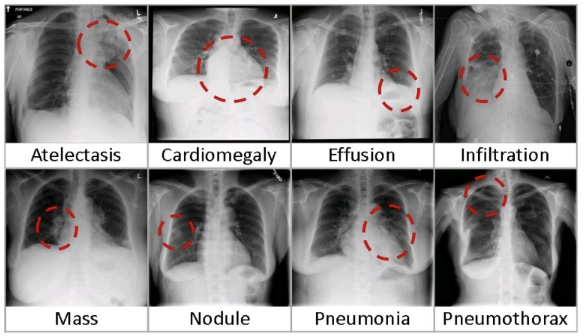

In [3]:
# Examples from the ChestX-ray8 article
from IPython.display import Image, display, Markdown

display(Markdown("### 🩻 Chest X-ray Examples"))
display(Image(filename="/content/drive/MyDrive/Colab Notebooks/Imagem.jpg"))

### 🗂️ 1.2 Loading the Annotation Data

Medical imaging datasets used for AI typically include one or more **annotation files**, usually in `.csv` or similar formats.

These files contain important **metadata**, such as:

- Image-level labels  
- Diagnostic findings  
- Patient demographics

This information is essential for **supervised learning** tasks, as it provides the **ground truth** needed to train and evaluate models.

Additionally, annotations often include context that helps with:

- Data filtering  
- Stratification  
- Analysis


In [4]:
# Loading and visualizing the annotations file
annotations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/image_index.csv')
annotations.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


###🔍 1.3 Understanding the Annotations File

The `image_index.csv` file contains metadata associated with each medical image in the dataset.  
This metadata is essential for preprocessing, training, and evaluating AI models.

---

### Column Descriptions

- **Image Index**: Filename of the corresponding X-ray image.

- **Finding Labels**: Diagnoses or findings observed in the image.  
  Multiple findings are separated by `|`.  
  If no pathology is found, the label is `"No Finding"`.

- **Follow-up #**: Indicates the exam sequence for a patient  
  (e.g., `0` for the first exam, `1` for a follow-up).

- **Patient ID**: Unique identifier for each patient.  
  Useful for grouping images and avoiding data leakage *(more on that later)*.

- **Patient Age**: Age of the patient at the time of the exam.

- **Patient Sex**: Sex of the patient (`M` for male, `F` for female).

- **View Position**: Position in which the X-ray was taken (e.g., `PA` for posteroanterior).

- **OriginalImage[Width] / [Height]**: Original resolution of the image in pixels.

- **OriginalImagePixelSpacing[x] / [y]**: Physical spacing between pixels (in millimeters).  
  This helps ensure accurate measurements and consistent image standardization.

---

> This metadata plays a critical role in structuring the data for reliable model training and evaluation.


## 🧹 2. Data Wrangling for Medicine AI

> In this part of the notebook, we'll focus on **data wrangling** — the process of cleaning, transforming, and organizing raw medical data into a structured and usable format.

---

### Why It’s Important

Medical data usually comes from a mix of sources, such as:

- Electronic Health Records (EHRs)
- Lab results
- Medical imaging (e.g., X-rays)

Because of that, it's often:

- Messy  
- Incomplete  
- Inconsistent

---

### What We'll Achieve

By wrangling this data, we will:

- **Improve Data Quality:** Ensure accuracy, consistency, and completeness — all crucial for model performance.
- **Enable Integration:** Combine and align data across different modalities.
- **Prepare for Modeling:** Convert the data into the format needed to train a **Convolutional Neural Network (CNN)**.

---

**By the end of this section**, we'll have a clean, well-structured dataset — ready for CNN-based training.


In [5]:
# Inspecting the structure of the dataset and check for missing values or incorrect data types.
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Sex                  112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


## 2.1 🔢 One-hot Encoding of Medical Findings

In the original dataset, the `Finding Labels` column can contain **one or more diagnoses per image**, stored as a single string separated by the `|` character. For example: `"Cardiomegaly|Emphysema"`.

⚠️ This format is **not directly usable** for training machine learning models, especially in **multi-label classification** tasks.

---

### What Should We Do

To make this data usable for modeling, we **convert** the `Finding Labels` column into multiple **binary columns**, one for each possible medical condition.

Each new column indicates whether a specific finding is present (`1`) or not (`0`) in the image. This transformation is known as **multi-label one-hot encoding**.

---

### Why This Matters

This format allows us to:

- **Train models** that can predict multiple findings at once
- **Compute class-wise performance metrics** (e.g., precision, recall, AUC)
- Ensure the labels are structured for loss functions like **binary cross-entropy**, commonly used in multi-label classification.

In [6]:
# Selecting the part of the dataset that we will use for model training
train_df = annotations.loc[:, 'Image Index':'Patient ID'].copy()
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID
0,00000001_000.png,Cardiomegaly,0,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1
3,00000002_000.png,No Finding,0,2
4,00000003_001.png,Hernia,0,3
...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801
112116,00030802_000.png,No Finding,0,30802
112117,00030803_000.png,No Finding,0,30803
112118,00030804_000.png,No Finding,0,30804


In [7]:
# Replace 'No Finding' with an empty string (optional)
train_df['Finding Labels'] = train_df['Finding Labels'].replace('No Finding', '')

# Perform one-hot encoding on the 'Finding Labels' column
findings_encoded = train_df['Finding Labels'].str.get_dummies(sep='|')

# Concatenate the one-hot columns with the original image and patient info
train_df_one_hot = pd.concat([train_df[['Image Index', 'Patient ID']], findings_encoded], axis=1)

# Display the result
train_df_one_hot.head()

,Image Index,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
